In [1]:

import sys
sys.path.insert(0, '../Triangulation/')
sys.path.insert(0, '../network_datasets')



In [2]:

from Triangulation import *
import Triangulation_with_points

import torch
import torch.optim as optim
import struct



import torch.nn as nn

from torch.autograd import Variable
from math import atan2,pow,acos
from  Neural_network import *

from torch.autograd.function import Function
from point_coordinates_regression import *
from bilinear_interpolation_grid import select_points


import matplotlib.cm as cm
import matplotlib.colors as colors
from functools import reduce

import itertools


%matplotlib qt

In [3]:

def get_median_edge_length_population(nb_of_edges,nb_of_points):
    with open('../polygon_datasets/'+str(nb_of_edges)+'_polygons_with_points/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons_with_points','rb') as file:
        polygons_with_points=pickle.load(file)

    polygons_edges_lengths=[]
    for polygon_with_points in polygons_with_points:
        triangles=get_elements(polygon_with_points[:2*nb_of_edges].reshape(nb_of_edges,2),polygon_with_points[2*nb_of_edges:].reshape(nb_of_points,2))
        triangles=np.array(triangles)
        triangles=triangles.reshape(len(triangles),3,2)

        edge_lengths_list=[]
        element_edge_length_list=[]
        for triangle in triangles:
            triangle_edge_lengths=[]
            for i in range(3):
                triangle_edge_lengths.append(compute_edge_lengths(triangle[int(i)],triangle[int((i+1)%3)]))
            element_edge_length_list.append(triangle_edge_lengths)
            triangle_edge_lengths_mean=np.array(triangle_edge_lengths).mean()
        edge_lengths_list.append(element_edge_length_list)
        polygons_edges_lengths.append(edge_lengths_list)
    merged=list(itertools.chain(*polygons_edges_lengths))
    merged = list(itertools.chain(*merged))
    merged = list(itertools.chain(*merged))
    return np.median(merged)


def get_elements(polygon,points):
    
    
    triangles_in_mesh=[]
    contour_connectivity=get_contour_edges(polygon)
    polygon_with_points=np.vstack([polygon,points])
    shape=dict(vertices=polygon_with_points,segments=contour_connectivity)

    t = tri.triangulate(shape, 'pq0')

    for triangle_index in t['triangles']:
        triangles_in_mesh.append(polygon_with_points[np.asarray([triangle_index])])
    return triangles_in_mesh


def unique_permutations(iterable, r=None):
    previous = tuple()
    for p in permutations(sorted(iterable), r):
        if p > previous:
            previous = p
            yield p



def l2_relative_error(A,B):
    A=np.array(A)
    B=np.array(B)
    diff=abs(B-A).flatten()
    maximum_error_index=np.argmax(diff)
    return np.linalg.norm(B-A)/np.linalg.norm(A),maximum_error_index


def get_grid_qualities(XX,YY,inner_points):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            qualities[index_x][index_y]=quality
    return qualities

def get_grid_qualities_with_penalty(XX,YY,inner_points,contour):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            for contour_point in contour:
                if np.linalg.norm(np.array([x,y])-contour_point)<0.2:
                    quality=2
                
            qualities[index_x][index_y]=quality
    return qualities


def get_grid_qualities_with_penalty_midpoint_included(XX,YY,inner_points,contour):
    qualities=np.empty([len(XX[0,:]),len(YY[:,0])])
    for index_x,x in enumerate(XX[0,:]):
        for index_y,y in enumerate(YY[:,0]):
            quality=np.min(np.array([np.linalg.norm(point-np.array([x,y]),2) for point in inner_points]))
            for index,contour_point in enumerate(contour):
                if np.linalg.norm(np.array([x,y])-contour_point)<0.13:
                    quality=1.3
                mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])
                if np.linalg.norm(np.array([x,y])-mid_point)<0.13:
                    quality=1.3


                
            qualities[index_x][index_y]=quality
    return qualities


def plot_grid_qualities(contour,grid_qualities,grid_points,inner_points):
    plt.clf()
    B=list(grid_qualities.flatten())
    cs = plt.scatter(grid_points[:,0],grid_points[:,1],c=B,cmap=cm.RdYlGn_r,vmin=min(grid_qualities.flatten()),vmax=max(grid_qualities.flatten()),s=4)
    plot_contour(contour)
    plot_contour(contour)
    plt.scatter(inner_points[:,0],inner_points[:,1],marker='o',c='b',label='Point location')
    plt.colorbar(cs)
    plt.legend()
    plt.show()
    

def seperate_to_sectors(grid_points,nb_sectors):
    grid_step_size=int(nb_of_grid_points/nb_sectors)
    sectors=[] 
    indices=[]
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            sector_points=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    sector_points.append(grid_points[index])
                    indices.append(index)
            sectors.append(sector_points) 
    return np.array(sectors),np.array(indices)


def get_qualities_by_sector(grid_points,inner_points,contour,nb_sectors,nb_of_edges,nb_of_points,outing_zone):
    
    

    
    grid_step_size=int(nb_of_grid_points/nb_sectors)
    quality_sectors=[] 
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            quality_point=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    grid_point=grid_points[index]
                    quality=np.min(np.array([np.linalg.norm(point-grid_point,2) for point in inner_points]))
                    for index,contour_point in enumerate(contour):
                        if np.linalg.norm(grid_point-contour_point)<outing_zone:
                            quality=1.3
                            

                        one_third=0.25*contour[index]+0.75*contour[(index+1)%len(contour)]
                        mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])
                        two_thirds=0.75*contour[index]+0.25* contour[(index+1)%len(contour)]
                        if np.linalg.norm(grid_point-mid_point)<outing_zone or np.linalg.norm(grid_point-one_third)<outing_zone or np.linalg.norm(grid_point-two_thirds)<outing_zone:
                            quality=1.3
                    quality_point.append(quality)
            quality_sectors.append(quality_point) 
    return np.array(quality_sectors)
    

    
    


def get_qualities_by_sector_updated(grid_points,inner_points,contour,nb_sectors,nb_of_edges,nb_of_points,outing_zone):
      
    grid_step_size=int(nb_of_grid_points/nb_sectors)
    quality_sectors=[] 
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            quality_point=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    grid_point=grid_points[index]
                    quality=np.min(np.array([np.linalg.norm(point-grid_point,2) for point in inner_points]))
                    for index,contour_point in enumerate(contour):
                        if np.linalg.norm(grid_point-contour_point)<outing_zone:
                            quality=1.3

                        one_third=0.25*contour[index]+0.75*contour[(index+1)%len(contour)]
                        two_thirds=0.75*contour[index]+0.25* contour[(index+1)%len(contour)]


                        mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])

                        one_fith=0.2*contour[index]+0.8*contour[(index+1)%len(contour)]
                        two_fifth=(2/5)*contour[index]+(3/5)*contour[(index+1)%len(contour)]
                        third_fifth=(3/5)*contour[index]+(2/5)*contour[(index+1)%len(contour)]
                        fourth_fith=0.8*contour[index]+0.2*contour[(index+1)%len(contour)]

                        one_sixth=(1/6)*contour[index]+(5/6)*contour[(index+1)%len(contour)]
                        two_sixth=(2/6)*contour[index]+(6/6)*contour[(index+1)%len(contour)]
                        fourth_sixth=(4/6)*contour[index]+(2/6)*contour[(index+1)%len(contour)]
                        fifth_sixth=(5/6)*contour[index]+(1/6)*contour[(index+1)%len(contour)]
                        condition1=np.linalg.norm(grid_point-one_sixth)<outing_zone or  np.linalg.norm(grid_point-two_sixth)<outing_zone or  np.linalg.norm(grid_point-fourth_sixth)<outing_zone or  np.linalg.norm(grid_point-fifth_sixth)<outing_zone
                        condition2=np.linalg.norm(grid_point-one_fith)<outing_zone or  np.linalg.norm(grid_point-two_fifth)<outing_zone or np.linalg.norm(grid_point-third_fifth)<outing_zone or  np.linalg.norm(grid_point-fourth_fith)<outing_zone or  np.linalg.norm(grid_point-fifth_sixth)<outing_zone

                        if  condition2 or condition1 or np.linalg.norm(grid_point-mid_point)<outing_zone or np.linalg.norm(grid_point-one_third)<outing_zone or np.linalg.norm(grid_point-two_thirds)<outing_zone:
                            quality=1.3
                    quality_point.append(quality)
            quality_sectors.append(quality_point) 
    return np.array(quality_sectors)
    
    
    

def get_qualities_by_sector_original(grid_points,inner_points,contour,nb_sectors):
    grid_step_size=int(nb_of_grid_points/nb_sectors)
    quality_sectors=[] 
    for q in range(nb_sectors):
        for k in range(nb_sectors):
            quality_point=[]
            for j in range(grid_step_size):
                for i in range(grid_step_size):
                    index=(grid_step_size*k+i+grid_step_size*nb_sectors*j)+(grid_step_size**2)*nb_sectors*q
                    grid_point=grid_points[index]
                    quality=np.min(np.array([np.linalg.norm(point-grid_point,2) for point in inner_points]))
                    for index,contour_point in enumerate(contour):
                        if np.linalg.norm(grid_point-contour_point)<0.13:
                            quality=1.3
                        mid_point=0.5*(contour[index]+contour[(index+1)%len(contour)])
                        if np.linalg.norm(grid_point-mid_point)<0.13:
                            quality=1.3
                    quality_point.append(quality)
            quality_sectors.append(quality_point) 
    return np.array(quality_sectors)
        

def plot_grid_qualities(contour,grid_qualities,grid_points,inner_points):
    B=list(grid_qualities.flatten())
    cs = plt.scatter(grid_points[:,0],grid_points[:,1],c=B,cmap=cm.RdYlGn_r,vmin=min(grid_qualities.flatten()),vmax=max(grid_qualities.flatten()),s=4)
    plot_contour(contour)
    plot_contour(contour)
    plt.scatter(inner_points[:,0],inner_points[:,1],marker='o',c='b',label='Point location')
    plt.colorbar(cs)
  #  plt.legend()
   # plt.show()
    
    
def batch_size_factor(n,minimum,maximum):    
    factor_set=set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
    for factor in factor_set:
        if factor>minimum and factor<maximum:
            div_factor=factor
        
    return div_factor




def save_grid_sector_qualities(filename,qualities):
    path=os.path.join('../polygon_datasets/polygon_sector_qualities/',filename)

    with open(path,'wb') as output:
        pickle.dump(qualities,output)
        
def load_grid_sector_qualities(filename):
    path=os.path.join('../polygon_datasets/polygon_sector_qualities/',filename)
        
    with open(path,'rb') as input:
        grid_qualities=pickle.load(input)        
    return grid_qualities
    
    
    

def save_grid_patch_NN(filename,net):
    path=os.path.join('../network_datasets/grid_patch_NN',filename)

    with open(path,'wb') as output:
        pickle.dump(net,output)
        
def load_grid_patch_NN(filename):
    path=os.path.join('../network_datasets/grid_patch_NN',filename)
        
    with open(path,'rb') as input:
        net=pickle.load(input)        
    net.eval()
    return net



In [30]:
# Gather the data and compute patch qualities
nb_of_points=11
grid_points_list=[20,40]
for nb_of_grid_points in grid_points_list:
    X=np.linspace(-1.3,1.3,nb_of_grid_points)
    Y=np.linspace(-1.3,1.3,nb_of_grid_points)
    XX,YY=np.meshgrid(X,Y)

    grid_points=np.array([[x,y] for x in X for y in Y])
    edges=[12]


    nb_sectors=int(nb_of_grid_points/2)# Grid will be divided into nb_sectors**2 patches
    for nb_of_edges in edges:
        points=[11]
        target_edge_length=get_median_edge_length_population(nb_of_edges,nb_of_points)
        outing_zone=0.2*target_edge_length

        polygons_initial=load_dataset(str(nb_of_edges)+'_polygons.pkl')              
        point_coordinates_initial=load_dataset(str(nb_of_edges)+'_point_coordinates_del.pkl')       
        number_of_insertion_points=load_dataset(str(nb_of_edges)+'_nb_of_points_del.pkl')
        for nb_of_points in points:
            grid_step_size=int(nb_of_grid_points/nb_sectors)
            polygons_reshaped,point_coordinates=reshape_data(polygons_initial,point_coordinates_initial,number_of_insertion_points,int(nb_of_points))                        
            sectors,indices=seperate_to_sectors(grid_points,nb_sectors)
            polygons_sectors=[]
            polygons_qualities_sector=[]
            for index,points in enumerate(point_coordinates):
                inner_points=points.reshape(nb_of_points,2)
                contour=np.delete(polygons_reshaped[index],2*nb_of_edges).reshape(nb_of_edges,2)    
                grid_qualities=get_qualities_by_sector_updated(grid_points,inner_points,contour,nb_sectors,nb_of_edges,nb_of_points,outing_zone)
                polygons_qualities_sector.append(grid_qualities)
            polygons_qualities_sector=np.array(polygons_qualities_sector)
            
            filename='../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons.pkl'
            
            if os.path.exists(filename):
                print("found additional data")
  
                additional_polygons=[]
                with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons.pkl'),'rb') as f:
                        try:
                            while True:
                                additional_polygons.append(pickle.load(f))
                        except EOFError:
                            pass
               
                additional_target_edge_lengths=[]
                with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_target_edge_lengths.pkl'),'rb') as f:
                        try:
                            while True:
                                additional_target_edge_lengths.append(pickle.load(f))
                        except EOFError:
                            pass
                
                
                additional_point_coordinates=[]
                with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_point_coordinates.pkl'),'rb') as f:
                        try:
                            while True:
                                additional_point_coordinates.append(pickle.load(f))
                        except EOFError:
                            pass

                additional_polygons=np.array(additional_polygons[-1])
                additional_polygons=additional_polygons.reshape(len(additional_polygons),2*nb_of_edges)

                additional_target_edge_lengths=np.array(additional_target_edge_lengths[-1])        
                additional_target_edge_lengths=np.array(additional_target_edge_lengths).reshape(len(additional_target_edge_lengths),1)
                additional_polygons_reshaped=np.hstack([additional_polygons,additional_target_edge_lengths])
                additional_point_coordinates=np.array(additional_point_coordinates[-1]).reshape(len(additional_point_coordinates[-1]),2*nb_of_points)



                additional_polygons_qualities_sector=[]
                for index,points in enumerate(additional_point_coordinates):
                    inner_points=points.reshape(nb_of_points,2)
                    contour=np.delete(additional_polygons_reshaped[index],2*nb_of_edges).reshape(nb_of_edges,2)    
                    additional_grid_qualities=get_qualities_by_sector_updated(grid_points,inner_points,contour,nb_sectors,nb_of_edges,nb_of_points,outing_zone)
                    additional_polygons_qualities_sector.append(additional_grid_qualities)
                additional_polygons_qualities_sector=np.array(additional_polygons_qualities_sector)
                polygons_qualities_sector=np.vstack([polygons_qualities_sector,additional_polygons_qualities_sector])
                
                
             
            filename2='../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons_part_2.pkl'
            
            if os.path.exists(filename2):
                print("found additional data part 2")

                with open('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons_part_2.pkl','rb') as f:
                    additional_polygons=pickle.load(f)

                with open('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_point_coordinates_part_2.pkl','rb') as f:
                    additional_point_coordinates=pickle.load(f)
                    additional_point_coordinates=np.array(additional_point_coordinates)



                additional_polygons_qualities_sector=[]
                for index,points in enumerate(additional_point_coordinates):
                    inner_points=points.reshape(nb_of_points,2)
                    contour=additional_polygons[index].reshape(nb_of_edges,2)    
                    grid_qualities=get_qualities_by_sector_updated(grid_points,inner_points,contour,nb_sectors,nb_of_edges,nb_of_points,outing_zone)
                    additional_polygons_qualities_sector.append(grid_qualities)

                polygons_qualities_sector=np.vstack([polygons_qualities_sector,additional_polygons_qualities_sector])
            
            save_grid_sector_qualities(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_sector_qualities_additional_v4.pkl',polygons_qualities_sector)
            print("done")

done
done


In [ ]:
additional_polygons=[]
with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons.pkl'),'rb') as f:
        try:
            while True:
                additional_polygons.append(pickle.load(f))
        except EOFError:
            pass


additional_target_edge_lengths=[]
with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_target_edge_lengths.pkl'),'rb') as f:
        try:
            while True:
                additional_target_edge_lengths.append(pickle.load(f))
        except EOFError:
            pass

additional_point_coordinates=[]        
with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_point_coordinates.pkl'),'rb') as f:
        try:
            while True:
                additional_point_coordinates.append(pickle.load(f))
        except EOFError:
            pass

additional_polygons=np.array(additional_polygons[-1])
additional_polygons=additional_polygons.reshape(len(additional_polygons),2*nb_of_edges)
additional_target_edge_lengths=np.array(additional_target_edge_lengths[-1])        
additional_target_edge_lengths=np.array(additional_target_edge_lengths).reshape(len(additional_target_edge_lengths),1)
additional_polygons_reshaped=np.hstack([additional_polygons,additional_target_edge_lengths])
additional_point_coordinates=np.array(additional_point_coordinates[-1]).reshape(len(additional_point_coordinates[-1]),2*nb_of_points)

In [124]:

point_coordinates.shape,additional_point_coordinates.shape

((619, 1, 4), (500, 4))

In [9]:
# Assemble data


nb_of_grid_points=20
X=np.linspace(-1.3,1.3,nb_of_grid_points)
Y=np.linspace(-1.3,1.3,nb_of_grid_points)
XX,YY=np.meshgrid(X,Y)

grid_points=np.array([[x,y] for x in X for y in Y])

nb_of_edges=8

nb_of_points=6
nb_sectors=int(nb_of_grid_points/2)
sectors,indices=seperate_to_sectors(grid_points,nb_sectors)

polygons_qualities_sector=load_grid_sector_qualities(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_sector_qualities_additional.pkl')


polygons_initial=load_dataset(str(nb_of_edges)+'_polygons.pkl')
number_of_insertion_points=load_dataset(str(nb_of_edges)+'_nb_of_points_del.pkl')
point_coordinates_initial=load_dataset(str(nb_of_edges)+'_point_coordinates_del.pkl')








polygons_reshaped,point_coordinates=reshape_data(polygons_initial,point_coordinates_initial,number_of_insertion_points,int(nb_of_points))



additional_polygons=[]
with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons.pkl'),'rb') as f:
        try:
            while True:
                additional_polygons.append(pickle.load(f))
        except EOFError:
            pass


additional_target_edge_lengths=[]
with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_target_edge_lengths.pkl'),'rb') as f:
        try:
            while True:
                additional_target_edge_lengths.append(pickle.load(f))
        except EOFError:
            pass

additional_point_coordinates=[]        
with open(os.path.join('../polygon_datasets/additional_polygon_datasets/'+str(nb_of_edges)+'_polygons/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_point_coordinates.pkl'),'rb') as f:
        try:
            while True:
                additional_point_coordinates.append(pickle.load(f))
        except EOFError:
            pass







additional_polygons=np.array(additional_polygons[-1])
additional_polygons=additional_polygons.reshape(len(additional_polygons),2*nb_of_edges)
additional_target_edge_lengths=np.array(additional_target_edge_lengths[-1])        
additional_target_edge_lengths=np.array(additional_target_edge_lengths).reshape(len(additional_target_edge_lengths),1)
additional_polygons_reshaped=np.hstack([additional_polygons,additional_target_edge_lengths])
additional_point_coordinates=np.array(additional_point_coordinates[-1]).reshape(len(additional_point_coordinates[-1]),1,2*nb_of_points)


polygons_reshaped=np.vstack([polygons_reshaped,additional_polygons_reshaped])
point_coordinates=np.vstack([point_coordinates,additional_point_coordinates])








polygons_qualities_sector=polygons_qualities_sector.reshape(int(polygons_qualities_sector.shape[0]*polygons_qualities_sector.shape[1]),1
                                                            ,int(polygons_qualities_sector.shape[2]))

In [204]:
polygons_reshaped_with_sector_grid_points=[]
for polygon in polygons_reshaped:
    for sector in sectors:
        polygons_reshaped_with_sector_grid_points.append( np.hstack([polygon,sector.reshape(2*len(sector))]))
polygons_reshaped_with_sector_grid_points=np.array(polygons_reshaped_with_sector_grid_points)


In [205]:
# 80/20 training/test data ratio

nb_of_test_data=int(len(polygons_reshaped_with_sector_grid_points)*0.2)
nb_of_training_data=int(len(polygons_reshaped_with_sector_grid_points)-nb_of_test_data)
nb_of_test_data,nb_of_training_data


(525320, 2101280)

In [206]:
# Shuffle the data
polygons_reshaped_with_sector_grid_points,polygons_qualities_sector=unison_shuffled_copies(polygons_reshaped_with_sector_grid_points,polygons_qualities_sector)


In [207]:
# Setting up the variables

x_tensor=torch.from_numpy(polygons_reshaped_with_sector_grid_points[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(polygons_reshaped_with_sector_grid_points[nb_of_training_data:]).type(torch.FloatTensor)
x_variable,x_variable_test=Variable(x_tensor),Variable(x_tensor_test)

y_tensor=torch.from_numpy(polygons_qualities_sector[:nb_of_training_data]).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(polygons_qualities_sector[nb_of_training_data:]).type(torch.FloatTensor)

y_variable,y_variable_test=Variable(y_tensor),Variable(y_tensor_test)



In [208]:
my_net=Net(x_variable.size()[1],y_variable.size()[2],nb_of_hidden_layers=3, nb_of_hidden_nodes=80,batch_normalization=True)
torch.cuda.empty_cache()
print("Training data length:",x_variable_test.size()[1],y_variable.size()[2])
x_variable.size()

Training data length: 25 4


torch.Size([2101280, 25])

In [209]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-4,weight_decay=0.2)
loss_func =torch.nn.MSELoss(size_average=False) 


In [210]:

if  torch.cuda.is_available():
    loss_func.cuda()
        
    x_variable , y_variable=x_variable.cuda(), y_variable.cuda()
    x_variable_test,y_variable_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_tensor_test.cuda(),volatile=True)

    print("cuda activated")
    

cuda activated


In [213]:
training_data_size=int(x_variable.size()[0])
print("Training data size: ",training_data_size)
batch_size_div=batch_size_factor(training_data_size,10,500)
batch_size=int(training_data_size/batch_size_div)
print("Batch size: ", batch_size)
nb_of_epochs=3000
my_net.cuda()
#my_net.cpu()

# Train the network #
my_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss= loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        
        sum_loss+=float(loss.data[0])

        
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        del loss
        del out
    if t%10==0: 
        my_net.eval()
        out_test=my_net(x_variable_test)   
        test_loss=loss_func(out_test,y_variable_test)
        print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0)),test_loss.data[0]/(x_variable_test.size(0)))
        my_net.train()


Training data size:  2101280
Batch size:  18272
Epoch: 0 Training Loss: 0.13487843558728935 0.13443216753597806


KeyboardInterrupt: 

In [212]:
save_grid_patch_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN_additional.pkl',my_net)


In [187]:
nb_of_edges=4

plt.clf()
for i in range(1000):
    random_contour=apply_procrustes(generate_contour(nb_of_edges))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length_jupyter(random_contour,1,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
          break
random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])

grid_step_size=int(nb_of_grid_points/nb_sectors)

plot_contour(random_contour)
random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
random_point_coordinated_delaunay.reshape(nb_of_points,2)
plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],marker='x',c='r',label='Point location')
my_net=load_grid_patch_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN.pkl')
my_net=my_net.cpu()
my_net.eval()
random_grid_qualities=[]
random_sector_qualities=[]

for sector in sectors:
    random_contour_with_sector_points=np.hstack([random_contour_with_target,sector.reshape(1,2*len(sector))])
    random_contour_with_sector_points=Variable(torch.from_numpy(random_contour_with_sector_points))
    random_contour_with_sector_points=random_contour_with_sector_points.expand(1000,random_contour_with_sector_points.shape[1]).type(torch.FloatTensor)
    random_sector_quality=my_net(random_contour_with_sector_points)
    random_sector_quality=random_sector_quality.data[0]
    random_sector_quality=random_sector_quality.numpy()
    random_sector_qualities.append(random_sector_quality)
random_sector_qualities=np.array(random_sector_qualities)

grid_qualities=np.empty((grid_step_size**2)*(nb_sectors**2))
for index,point_index in enumerate(indices):
    grid_qualities[point_index]=random_sector_qualities.flatten()[index]

    
    

grid_qualities_duplicate=grid_qualities.flatten()

predicted_points=[]
label_added=False
for i in range(nb_of_points):
    minimum_index=np.argmin(grid_qualities_duplicate)
    surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
    surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
    
    
    
    surrounding_points=grid_points[np.asarray(surrounding_points_index)]
    surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
    point_maximum=grid_points[minimum_index]
    if not label_added:
        
        plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=70,c='y',label='Predictions')
        label_added=True
    plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=70,c='y')
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='d',s=34)
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
    predicted_points.append(point_maximum)
    grid_qualities_duplicate[minimum_index]=100
    grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
    grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
plot_contour(random_contour)
plt.legend()
plot_grid_qualities(random_contour,grid_qualities,grid_points,random_point_coordinated_delaunay)


5 0.1673610639569033 -0.1246313527519371 0
5 -1.387778780781446e-16 -2.42861286636753e-17 0
5 0.05484732470888349 -0.04947690071237799 0
5 1.214306433183765e-17 2.775557561562891e-17 0
5 -8.326672684688674e-17 8.326672684688674e-17 0


KeyboardInterrupt: 

In [ ]:
import scipy

predicted_points=np.array(predicted_points)
y=predicted_points
x=random_point_coordinated_delaunay

dist = scipy.spatial.distance.directed_hausdorff(y,x)
regression_error(x,y,6),dist

In [ ]:
#  Testing convengenge of points with multiple grid resolutions


nb_of_edges=6
nb_of_points=1
nb_of_grid_points_list=[10,20,40]

plt.clf()
random_contour_list=[]
for i in range(1000):
    random_contour=apply_procrustes(generate_contour(nb_of_edges))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,1,algorithm='del2d')
    if random_nb_of_points==nb_of_points:
          break
random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])

predicted_points_grid_resolution=[]

for nb_of_grid_points in nb_of_grid_points_list:

    X=np.linspace(-1.3,1.3,nb_of_grid_points)
    Y=np.linspace(-1.3,1.3,nb_of_grid_points)
    XX,YY=np.meshgrid(X,Y)
    grid_points=np.array([[x,y] for x in X for y in Y])


    nb_sectors=int(nb_of_grid_points/2)
    sectors,indices=seperate_to_sectors(grid_points,nb_sectors)







    grid_step_size=int(nb_of_grid_points/nb_sectors)

    plot_contour(random_contour)
    random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
    random_point_coordinated_delaunay.reshape(nb_of_points,2)
    plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],marker='x',c='r',label='Point location')
    my_net=load_grid_patch_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN.pkl')
    my_net=my_net.cpu()
    my_net.eval()
    random_grid_qualities=[]
    random_sector_qualities=[]

    for sector in sectors:
        random_contour_with_sector_points=np.hstack([random_contour_with_target,sector.reshape(1,2*len(sector))])
        random_contour_with_sector_points=Variable(torch.from_numpy(random_contour_with_sector_points))
        random_contour_with_sector_points=random_contour_with_sector_points.expand(1000,random_contour_with_sector_points.shape[1]).type(torch.FloatTensor)
        random_sector_quality=my_net(random_contour_with_sector_points)
        random_sector_quality=random_sector_quality.data[0]
        random_sector_quality=random_sector_quality.numpy()
        random_sector_qualities.append(random_sector_quality)
    random_sector_qualities=np.array(random_sector_qualities)

    grid_qualities=np.empty((grid_step_size**2)*(nb_sectors**2))
    for index,point_index in enumerate(indices):
        grid_qualities[point_index]=random_sector_qualities.flatten()[index]

    
    

    grid_qualities_duplicate=grid_qualities.flatten()

    predicted_points=[]
    label_added=False
    for i in range(nb_of_points):
        minimum_index=np.argmin(grid_qualities_duplicate)
        surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
        surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
        
        surrounding_points_index_3_ring=np.append(surrounding_points_index_2_ring
                                                ,
                                             [ minimum_index+3,minimum_index+3,
                        minimum_index+3*nb_of_grid_points,
                        minimum_index+3*nb_of_grid_points+3,minimum_index+3*nb_of_grid_points-3,
                        minimum_index+3*nb_of_grid_points+2,minimum_index+3*nb_of_grid_points-2,                      
                                              
                                              
                        minimum_index-3*nb_of_grid_points,
                        minimum_index-3*nb_of_grid_points+2,minimum_index-3*nb_of_grid_points-2, 
                        minimum_index-3*nb_of_grid_points+3, minimum_index-3*nb_of_grid_points-3 ,
                                              
                        minimum_index+3,
                        minimum_index-3 ,
                        minimum_index+nb_of_grid_points+3,
                        minimum_index+nb_of_grid_points-3,
                                              
                        minimum_index-nb_of_grid_points+3,
                        minimum_index-nb_of_grid_points-3] )
    
    
        surrounding_points=grid_points[np.asarray(surrounding_points_index)]
        if int(nb_of_grid_points)>10:
            surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
        point_maximum=grid_points[minimum_index]
        if not label_added:
        
            plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=70,c='y',label='Predictions')
            label_added=True
        plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=70,c='y')
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='d',s=34)
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
        predicted_points.append(point_maximum)
        grid_qualities_duplicate[minimum_index]=100
        grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
        if int(nb_of_grid_points)>10:
            grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
        if int(nb_of_grid_points)>20:
            grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
    predicted_points_grid_resolution.append(predicted_points)

    plot_contour(random_contour)
    
    plt.legend()
    plot_grid_qualities(random_contour,grid_qualities,grid_points,random_point_coordinated_delaunay)
    random_contour_list.append(random_contour)
    
    plt.figure()



In [73]:
#  Mean error convergence

nb_of_edges=10
nb_of_points=1
nb_of_grid_points_list=[10,20,40]
errors_in_grid_resolution=[]

with open('../polygon_datasets/validation_sets/grid_patch_regression/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_polygon_data.pkl','rb') as f:
    contours=pickle.load(f)

for random_contour in contours:
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,1,algorithm='del2d')
  
    random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
    random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])
    
    predicted_points_grid_resolution=[]
    errors=[]

    for nb_of_grid_points in nb_of_grid_points_list:

        X=np.linspace(-1.3,1.3,nb_of_grid_points)
        Y=np.linspace(-1.3,1.3,nb_of_grid_points)
        XX,YY=np.meshgrid(X,Y)
        grid_points=np.array([[x,y] for x in X for y in Y])
    

        nb_sectors=int(nb_of_grid_points/2)
        sectors,indices=seperate_to_sectors(grid_points,nb_sectors)







        grid_step_size=int(nb_of_grid_points/nb_sectors)

        random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
        random_point_coordinated_delaunay.reshape(nb_of_points,2)
        my_net=load_grid_patch_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN.pkl')
        my_net=my_net.cpu()
        my_net.eval()
        random_grid_qualities=[]
        random_sector_qualities=[]

        for sector in sectors:
            random_contour_with_sector_points=np.hstack([random_contour_with_target,sector.reshape(1,2*len(sector))])
            random_contour_with_sector_points=Variable(torch.from_numpy(random_contour_with_sector_points))
            random_contour_with_sector_points=random_contour_with_sector_points.expand(1000,random_contour_with_sector_points.shape[1]).type(torch.FloatTensor)
            random_sector_quality=my_net(random_contour_with_sector_points)
            random_sector_quality=random_sector_quality.data[0]
            random_sector_quality=random_sector_quality.numpy()
            random_sector_qualities.append(random_sector_quality)
        random_sector_qualities=np.array(random_sector_qualities)

        grid_qualities=np.empty((grid_step_size**2)*(nb_sectors**2))
        for index,point_index in enumerate(indices):
            grid_qualities[point_index]=random_sector_qualities.flatten()[index]

    
    

        grid_qualities_duplicate=grid_qualities.flatten()

        predicted_points=[]
        label_added=False
        for i in range(nb_of_points):
            minimum_index=np.argmin(grid_qualities_duplicate)
            surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                            ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                            minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
            surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                            minimum_index+2*nb_of_grid_points,
                            minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                            minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                            minimum_index-2*nb_of_grid_points,
                            minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                            minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                            minimum_index+2,
                            minimum_index-2 ,
                            minimum_index+nb_of_grid_points+2,
                            minimum_index+nb_of_grid_points-2,
                                              
                            minimum_index-nb_of_grid_points+2,
                            minimum_index-nb_of_grid_points-2,


                                                                    
                    ])
        
            surrounding_points_index_3_ring=np.append(surrounding_points_index_2_ring
                                                    ,
                                                 [ minimum_index+3,minimum_index+3,
                            minimum_index+3*nb_of_grid_points,
                            minimum_index+3*nb_of_grid_points+3,minimum_index+3*nb_of_grid_points-3,
                            minimum_index+3*nb_of_grid_points+2,minimum_index+3*nb_of_grid_points-2,                      
                                              
                                              
                            minimum_index-3*nb_of_grid_points,
                            minimum_index-3*nb_of_grid_points+2,minimum_index-3*nb_of_grid_points-2, 
                            minimum_index-3*nb_of_grid_points+3, minimum_index-3*nb_of_grid_points-3 ,
                                              
                            minimum_index+3,
                            minimum_index-3 ,
                            minimum_index+nb_of_grid_points+3,
                            minimum_index+nb_of_grid_points-3,
                                              
                            minimum_index-nb_of_grid_points+3,
                            minimum_index-nb_of_grid_points-3] )
    
    
            surrounding_points=grid_points[np.asarray(surrounding_points_index)]
            if int(nb_of_grid_points)>10:
                surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
            point_maximum=grid_points[minimum_index]
       
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='d',s=34)
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
            error=np.linalg.norm(random_point_coordinated_delaunay.reshape(2)-point_maximum)
            print(error)
            predicted_points.append(point_maximum)
            grid_qualities_duplicate[minimum_index]=100
            grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
            if int(nb_of_grid_points)>10:
                grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
            if int(nb_of_grid_points)>20:
                grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
            predicted_points_grid_resolution.append(predicted_points)
            errors.append(error)
    errors_in_grid_resolution.append(errors)


11 -0.07773575816372752 0.003668377205892672 0
1.1732680851978492
0.48270562630468994
0.6181468189023783
11 -0.3574843338093715 -0.6165514376082681 0
1.35561827470588
0.6196809658687001
0.3696162804120583
11 -0.0551597755170004 0.03654949628308437 -0
1.2466327091430083
0.3102972830386777
0.25461803824568857
11 0.04743876531221136 -0.03447790910816691 0
1.1145272615918007
0.42533769092311746
0.17801449403418684
11 -0.06033574411241775 0.06911362276797743 -0
1.2419509652235732
0.48629538354329654
0.38081329097398753
11 -0.0519964694359893 0.08811008502748179 0
0.9986734691171557
0.2826788961641538
0.4692293230376508
11 0.1065769481340493 -0.0006473960144732394 0
1.0124669002085005
0.5638343744079134
0.29119061000289187
11 -0.02871259585143025 0.06913049140073888 -0
1.0491968016469306
0.7532133313301277
0.40579658421622894
11 -0.02823369808016717 -0.04035539479308997 0
0.8634988919824975
0.49476409959155526
0.42465982740416247
11 -0.01902564629091782 -0.06893638121740087 0
1.1709531297758

0.7652948449438203
0.8559231933573915
11 -0.06159656639545863 0.08272582442490968 -0
1.3279597550987732
0.28087320173953867
0.2668488345025709
11 0.06364233547563668 -0.01742715695026552 0
1.0929603848098595
0.3280129991563984
0.27443517946534357
11 0.1507492241228738 -0.003524516491522045 0
1.7703555484968863
0.09026590658565374
0.6778896069198181
11 0.04657298249940622 -0.06437570959620148 0
0.5233697819990302
0.20692402428230133
0.40005875677901886
11 -0.006781678210243977 -0.3429926419977565 0
1.608812205039217
0.6239985437361966
0.5558928710600918
11 0.09287392189835847 0.08823588029951428 0
1.3018672080127431
1.114819881151033
0.4306715239551291
11 -0.101168158976761 0.02270632077181692 0
0.774374715132994
0.38192962069352593
0.767601727198867
11 -0.1709341264688984 -0.02893628256866678 0
1.5744616618977043
0.3348735278811882
0.33243126591739064
11 -0.0946278287303715 0.06370992916113422 -0
0.21403256399981385
0.5964243650036701
0.2635288122803646
11 -0.006032623229242833 -0.0267

In [ ]:
#polygons_qualities_sector=polygons_qualities_sector.reshape(len(polygons_qualities_sector),1,16*100)

plot_contour(random_contour)
grid_resolution=['100 grid','400 grid','1600 grid']
for index,_ in enumerate(predicted_points_grid_resolution):
    points=predicted_points_grid_resolution[index]
    points=np.array(points)
    print(points)
    plt.scatter(points[:,0],points[:,1],label=grid_resolution[index])
plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],marker='x',label='Point location')
plt.legend()

In [74]:
errors_in_grid_resolution=np.array(errors_in_grid_resolution)
errors_in_grid_resolution_10=errors_in_grid_resolution

In [72]:
x_label=[10,20,40]
y_label=[]
for i in range(3):
    y_label.append( errors_in_grid_resolution_6[:,i].mean())
plt.plot(x_label,y_label)
plt.xlabel('resolution')
plt.ylabel('mean error')

Text(0, 0.5, 'mean error')

In [ ]:
plt.plot(x_label,y_label)
plt.xlabel('resolution')
plt.ylabel('mean error')

In [79]:
mean_errors=[errors_in_grid_resolution_4,errors_in_grid_resolution_6,errors_in_grid_resolution_8,errors_in_grid_resolution_10]
with open('../polygon_datasets/validation_sets/grid_patch_regression/mean_grid_errors.pkl','wb') as f:
    pickle.dump(mean_errors,f)

In [81]:

with open('../polygon_datasets/validation_sets/grid_patch_regression/mean_grid_errors.pkl','rb') as f:
    mean_errors=pickle.load(f)

#mean_errors=load_dataset('mean_grid_errors.pkl')
mean_errors.append(errors_in_grid_resolution_10)
title_label=['4 polygons','6 polygons','8 polygons','10 polygons']
graphs=[]
for index,errors in enumerate(mean_errors):
    x_label=[10,20,40]
    y_label=[]
    for i in range(3):
        y_label.append( errors[:,i].mean())
    p,=plt.plot(x_label,y_label,'-o')
    graphs.append(p)
    plt.xlabel('resolution')
    plt.ylabel('mean error')
plt.legend(graphs,title_label)


In [127]:
nb_of_edges=8
nb_of_points=2

In [128]:
with open('../polygon_datasets/'+str(nb_of_edges)+'_polygons_with_points/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons_with_points','rb') as f:
    polygons_with_points=pickle.load(f)
    
with open('../polygon_datasets/'+str(nb_of_edges)+'_polygons_with_points/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_polygons_qualities_min.pkl','rb') as f:
    qualities=pickle.load(f)

    
polygons_with_points_reshaped,qualities_reshaped=reshape_data_for_conv2d(polygons_with_points,qualities)

len(qualities_reshaped),len(polygons_with_points_reshaped)

NameError: name 'reshape_data_for_conv2d' is not defined

In [631]:
random_sector_qualities.shape
indices

[]

In [638]:
random_sector_quality

array([1.5233474, 1.6236854, 1.6400616, 1.7441411, 1.7478435, 1.803707 ,
       1.4108682, 1.4614108, 1.4753969, 1.5183129, 1.5692446, 1.6470757,
       1.6340151, 1.7031217, 1.7529109, 1.8057061], dtype=float32)

In [637]:
indices

[0,
 1,
 2,
 3,
 40,
 41,
 42,
 43,
 80,
 81,
 82,
 83,
 120,
 121,
 122,
 123,
 4,
 5,
 6,
 7,
 44,
 45,
 46,
 47,
 84,
 85,
 86,
 87,
 124,
 125,
 126,
 127,
 8,
 9,
 10,
 11,
 48,
 49,
 50,
 51,
 88,
 89,
 90,
 91,
 128,
 129,
 130,
 131,
 12,
 13,
 14,
 15,
 52,
 53,
 54,
 55,
 92,
 93,
 94,
 95,
 132,
 133,
 134,
 135,
 16,
 17,
 18,
 19,
 56,
 57,
 58,
 59,
 96,
 97,
 98,
 99,
 136,
 137,
 138,
 139,
 20,
 21,
 22,
 23,
 60,
 61,
 62,
 63,
 100,
 101,
 102,
 103,
 140,
 141,
 142,
 143,
 24,
 25,
 26,
 27,
 64,
 65,
 66,
 67,
 104,
 105,
 106,
 107,
 144,
 145,
 146,
 147,
 28,
 29,
 30,
 31,
 68,
 69,
 70,
 71,
 108,
 109,
 110,
 111,
 148,
 149,
 150,
 151,
 32,
 33,
 34,
 35,
 72,
 73,
 74,
 75,
 112,
 113,
 114,
 115,
 152,
 153,
 154,
 155,
 36,
 37,
 38,
 39,
 76,
 77,
 78,
 79,
 116,
 117,
 118,
 119,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 200,
 201,
 202,
 203,
 240,
 241,
 242,
 243,
 280,
 281,
 282,
 283,
 164,
 165,
 166,
 167,
 204,
 205,
 206,
 207,
 244,


In [88]:
grid_qualities=np.empty(100*grid_step_size**2)

In [89]:
for point_index,index in enumerate(indices):
    grid_qualities[point_index]=random_sector_qualities.flatten()[index]

In [90]:
random_sector_qualities.shape

(4, 25)

In [91]:
indices

array([ 0,  1,  2,  3,  4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31,
       32, 33, 34, 40, 41, 42, 43, 44,  5,  6,  7,  8,  9, 15, 16, 17, 18,
       19, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 60, 61, 62, 63, 64, 70, 71, 72, 73, 74, 80, 81, 82,
       83, 84, 90, 91, 92, 93, 94, 55, 56, 57, 58, 59, 65, 66, 67, 68, 69,
       75, 76, 77, 78, 79, 85, 86, 87, 88, 89, 95, 96, 97, 98, 99])

In [92]:
print(indices)

[ 0  1  2  3  4 10 11 12 13 14 20 21 22 23 24 30 31 32 33 34 40 41 42 43
 44  5  6  7  8  9 15 16 17 18 19 25 26 27 28 29 35 36 37 38 39 45 46 47
 48 49 50 51 52 53 54 60 61 62 63 64 70 71 72 73 74 80 81 82 83 84 90 91
 92 93 94 55 56 57 58 59 65 66 67 68 69 75 76 77 78 79 85 86 87 88 89 95
 96 97 98 99]


In [93]:
indices[44]

39

In [94]:
grid_qualities

array([1.55924475, 1.43339157, 1.16775644, ..., 0.        , 0.        ,
       0.        ])

In [109]:
grid_qualities_duplicate=grid_qualities.flatten()

predicted_points=[]
label_added=False
for i in range(nb_of_points):
    minimum_index=np.argmin(grid_qualities_duplicate)
    surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
    surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
    
    surrounding_points=grid_points[np.asarray(surrounding_points_index)]
    surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
    point_maximum=grid_points[minimum_index]
    if not label_added:
        plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y',label='Predictions')
        label_added=True
    plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=30,c='y')
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='d',s=34)
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
    predicted_points.append(point_maximum)
    grid_qualities_duplicate[minimum_index]=100
    grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
    #grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100


In [691]:
inner_points

array([[ 0.08272188,  0.21544542],
       [-0.66972537, -0.25235211],
       [ 0.32146268, -0.11978039]])

In [732]:
for index,point_index in enumerate(indices):
    print(index,point_index)

0 0
1 1
2 2
3 3
4 40
5 41
6 42
7 43
8 80
9 81
10 82
11 83
12 120
13 121
14 122
15 123
16 4
17 5
18 6
19 7
20 44
21 45
22 46
23 47
24 84
25 85
26 86
27 87
28 124
29 125
30 126
31 127
32 8
33 9
34 10
35 11
36 48
37 49
38 50
39 51
40 88
41 89
42 90
43 91
44 128
45 129
46 130
47 131
48 12
49 13
50 14
51 15
52 52
53 53
54 54
55 55
56 92
57 93
58 94
59 95
60 132
61 133
62 134
63 135
64 16
65 17
66 18
67 19
68 56
69 57
70 58
71 59
72 96
73 97
74 98
75 99
76 136
77 137
78 138
79 139
80 20
81 21
82 22
83 23
84 60
85 61
86 62
87 63
88 100
89 101
90 102
91 103
92 140
93 141
94 142
95 143
96 24
97 25
98 26
99 27
100 64
101 65
102 66
103 67
104 104
105 105
106 106
107 107
108 144
109 145
110 146
111 147
112 28
113 29
114 30
115 31
116 68
117 69
118 70
119 71
120 108
121 109
122 110
123 111
124 148
125 149
126 150
127 151
128 32
129 33
130 34
131 35
132 72
133 73
134 74
135 75
136 112
137 113
138 114
139 115
140 152
141 153
142 154
143 155
144 36
145 37
146 38
147 39
148 76
149 77
150 78
151 79
152 

1438 1438
1439 1439
1440 1440
1441 1441
1442 1442
1443 1443
1444 1480
1445 1481
1446 1482
1447 1483
1448 1520
1449 1521
1450 1522
1451 1523
1452 1560
1453 1561
1454 1562
1455 1563
1456 1444
1457 1445
1458 1446
1459 1447
1460 1484
1461 1485
1462 1486
1463 1487
1464 1524
1465 1525
1466 1526
1467 1527
1468 1564
1469 1565
1470 1566
1471 1567
1472 1448
1473 1449
1474 1450
1475 1451
1476 1488
1477 1489
1478 1490
1479 1491
1480 1528
1481 1529
1482 1530
1483 1531
1484 1568
1485 1569
1486 1570
1487 1571
1488 1452
1489 1453
1490 1454
1491 1455
1492 1492
1493 1493
1494 1494
1495 1495
1496 1532
1497 1533
1498 1534
1499 1535
1500 1572
1501 1573
1502 1574
1503 1575
1504 1456
1505 1457
1506 1458
1507 1459
1508 1496
1509 1497
1510 1498
1511 1499
1512 1536
1513 1537
1514 1538
1515 1539
1516 1576
1517 1577
1518 1578
1519 1579
1520 1460
1521 1461
1522 1462
1523 1463
1524 1500
1525 1501
1526 1502
1527 1503
1528 1540
1529 1541
1530 1542
1531 1543
1532 1580
1533 1581
1534 1582
1535 1583
1536 1464
1537 1465


In [899]:
random_real_polygon_qualities=[]
 
grid_qualities=get_qualities_by_sector(grid_points,random_point_coordinated_delaunay,random_contour,10)
random_real_polygon_qualities.append(grid_qualities)
random_real_polygon_qualities=np.array(random_real_polygon_qualities)

In [900]:
real_grid_qualities=np.empty((grid_step_size**2)*16)
for index,point_index in enumerate(indices):
    real_grid_qualities[point_index]=random_real_polygon_qualities.flatten()[index]


In [901]:
plot_grid_qualities(random_contour,real_grid_qualities,grid_points,random_point_coordinated_delaunay)

In [902]:
random_real_polygon_qualities

array([[[1.36106118, 1.31407418, 1.26885116, ..., 1.17786247,
         1.12718779, 1.07825485],
        [1.1844976 , 1.14581566, 1.10979341, ..., 0.98664208,
         0.94456893, 0.90545415],
        [1.04680648, 1.02040107, 0.99775838, ..., 0.83772753,
         0.80999434, 0.78694545],
        ...,
        [0.95955597, 1.01189422, 1.0658335 , ..., 1.14368457,
         1.19167342, 1.24138857],
        [1.17762898, 1.23513069, 1.29351247, ..., 1.34522574,
         1.39902073, 1.45388259],
        [1.41247817, 1.47288422, 1.53380905, ..., 1.56635641,
         1.6237779 , 1.68188163]]])

In [903]:
grid_qualities=get_qualities_by_sector(grid_points,random_point_coordinated_delaunay,contour,10)


In [814]:
for i,index in enumerate(indices):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [808]:
real_grid_qualities

array([1.33378286, 1.28589651, 1.23974669, ..., 1.75377898, 1.78892334,
       1.82582629])

In [38]:
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

In [180]:
xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [66]:
polygons_reshaped[0]

array([ 0.81919787,  0.01995175,  1.10463669,  0.8737783 ,  0.28285633,
        0.54723589, -0.39506706,  0.51866466, -1.20287247,  0.54403433,
       -0.55997494, -0.0900743 , -0.78691654, -0.359835  , -0.30738516,
       -0.48594082,  0.33257866, -0.59309277,  0.71294662, -0.97472204,
        0.2       ])

In [67]:
random_contour=np.delete(polygons_reshaped[0],20)

In [70]:
random_contour=random_contour.reshape(10,2)

In [71]:
get_extrapoints_target_length(random_contour,1,algorithm='del2d')

11 0.02870094994343705 -0.01387593125550157 0


(1, [array([ 0.02870095, -0.01387593])])

In [75]:
len(polygons_reshaped)

82

In [77]:
len(polygons_initial)

20000

In [80]:
plot_contour(get_reference_polygon(14))

In [81]:
contour=get_reference_polygon(14)

In [82]:
get_extrapoints_target_length(contour,1,algorithm='del2d')

15 3.587575868819268e-17 2.887302292429496e-17 0
16 -0.2021734630193171 0.5154152002968003 0
17 -0.5290209225336119 -0.1632905427999433 0
18 0.2021734630193171 -0.5154152002968003 0
19 0.529020922533612 0.1632905427999433 0
20 -0.2515747331176337 -0.5224003161557412 0
21 0.2515747331176337 0.5224003161557413 0
22 -0.544194135853177 0.2620700835307863 0
23 0.5426088425523469 -0.2613066465137408 0
24 0.5760329550896213 0.4748883394479863 0
25 0.01213198140447151 0.7464487358956065 0
26 -0.5760329550896213 -0.4748883394479861 0
27 -0.01213198140447158 -0.7464487358956065 0


(13,
 [array([3.58757587e-17, 2.88730229e-17]),
  array([-0.20217346,  0.5154152 ]),
  array([-0.52902092, -0.16329054]),
  array([ 0.20217346, -0.5154152 ]),
  array([0.52902092, 0.16329054]),
  array([-0.25157473, -0.52240032]),
  array([0.25157473, 0.52240032]),
  array([-0.54419414,  0.26207008]),
  array([ 0.54260884, -0.26130665]),
  array([0.57603296, 0.47488834]),
  array([0.01213198, 0.74644874]),
  array([-0.57603296, -0.47488834]),
  array([-0.01213198, -0.74644874])])

In [8]:
random_contour_list

[]

11 -0.07773575816372752 0.003668377205892672 0
[[ 0.41218306 -0.04974281]
 [ 0.50599367  0.50880698]
 [ 0.32748924  1.26930747]
 [-0.10308144  0.49583786]
 [-0.94114348  0.74697035]
 [-0.67585247  0.15999244]
 [-0.34185332 -0.41240268]
 [-0.2847575  -1.27533625]
 [ 0.31926951 -0.53935919]
 [ 0.78175272 -0.90407418]]


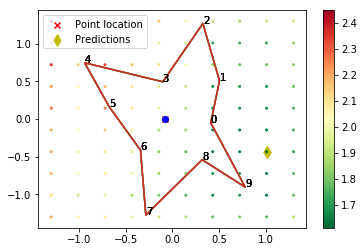

[[ 0.41218306 -0.04974281]
 [ 0.50599367  0.50880698]
 [ 0.32748924  1.26930747]
 [-0.10308144  0.49583786]
 [-0.94114348  0.74697035]
 [-0.67585247  0.15999244]
 [-0.34185332 -0.41240268]
 [-0.2847575  -1.27533625]
 [ 0.31926951 -0.53935919]
 [ 0.78175272 -0.90407418]]


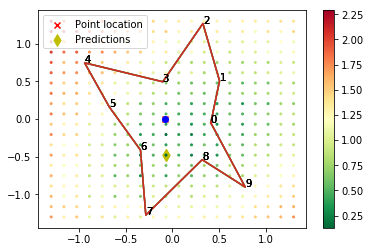

[[ 0.41218306 -0.04974281]
 [ 0.50599367  0.50880698]
 [ 0.32748924  1.26930747]
 [-0.10308144  0.49583786]
 [-0.94114348  0.74697035]
 [-0.67585247  0.15999244]
 [-0.34185332 -0.41240268]
 [-0.2847575  -1.27533625]
 [ 0.31926951 -0.53935919]
 [ 0.78175272 -0.90407418]]


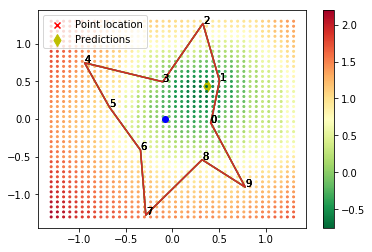

11 -0.3574843338093715 -0.6165514376082681 0
[[ 0.48379027 -0.00383973]
 [ 0.59474348  0.81947877]
 [ 0.54267512  1.18125073]
 [-0.15446632  0.4551376 ]
 [-0.8698474   0.64311742]
 [-0.37612076 -0.05849659]
 [-0.73647936 -0.66514771]
 [-0.56169485 -0.98831003]
 [ 0.12399917 -0.70012677]
 [ 0.95340064 -0.68306369]]


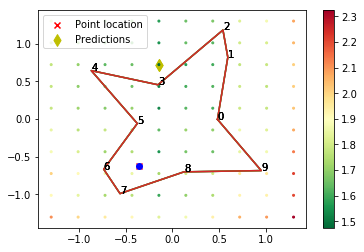

[[ 0.48379027 -0.00383973]
 [ 0.59474348  0.81947877]
 [ 0.54267512  1.18125073]
 [-0.15446632  0.4551376 ]
 [-0.8698474   0.64311742]
 [-0.37612076 -0.05849659]
 [-0.73647936 -0.66514771]
 [-0.56169485 -0.98831003]
 [ 0.12399917 -0.70012677]
 [ 0.95340064 -0.68306369]]


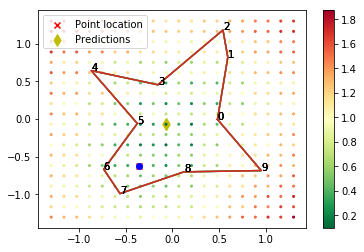

[[ 0.48379027 -0.00383973]
 [ 0.59474348  0.81947877]
 [ 0.54267512  1.18125073]
 [-0.15446632  0.4551376 ]
 [-0.8698474   0.64311742]
 [-0.37612076 -0.05849659]
 [-0.73647936 -0.66514771]
 [-0.56169485 -0.98831003]
 [ 0.12399917 -0.70012677]
 [ 0.95340064 -0.68306369]]


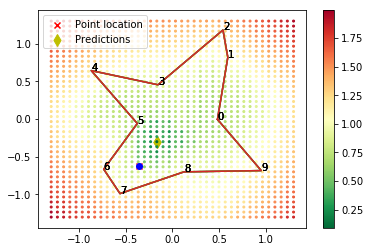

11 -0.0551597755170004 0.03654949628308437 -0
[[ 1.16497778 -0.36546658]
 [ 0.29977667  0.35892047]
 [ 0.56054013  1.11448423]
 [-0.32769007  0.79560075]
 [-1.00192213  0.63959014]
 [-0.52674559 -0.05010932]
 [-0.83393135 -0.68411359]
 [-0.16105895 -0.58295323]
 [ 0.4961066  -0.97685263]
 [ 0.3299469  -0.24910025]]


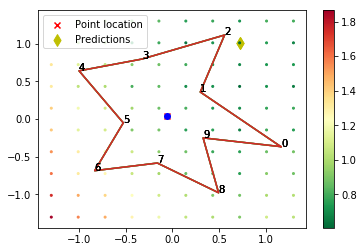

[[ 1.16497778 -0.36546658]
 [ 0.29977667  0.35892047]
 [ 0.56054013  1.11448423]
 [-0.32769007  0.79560075]
 [-1.00192213  0.63959014]
 [-0.52674559 -0.05010932]
 [-0.83393135 -0.68411359]
 [-0.16105895 -0.58295323]
 [ 0.4961066  -0.97685263]
 [ 0.3299469  -0.24910025]]


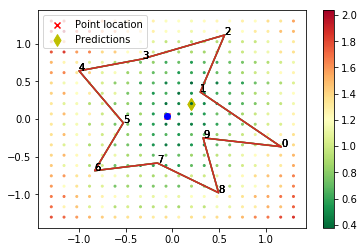

[[ 1.16497778 -0.36546658]
 [ 0.29977667  0.35892047]
 [ 0.56054013  1.11448423]
 [-0.32769007  0.79560075]
 [-1.00192213  0.63959014]
 [-0.52674559 -0.05010932]
 [-0.83393135 -0.68411359]
 [-0.16105895 -0.58295323]
 [ 0.4961066  -0.97685263]
 [ 0.3299469  -0.24910025]]


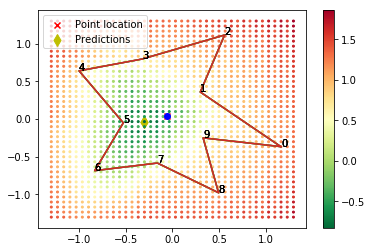

11 0.04743876531221136 -0.03447790910816691 0
[[ 1.09251426  0.26099942]
 [ 0.5628476   0.25290834]
 [ 0.36518076  1.1214356 ]
 [-0.03529952  0.46030288]
 [-1.12143859  0.5935934 ]
 [-0.64061702  0.00568844]
 [-0.75227927 -0.54743651]
 [-0.19792689 -0.47202716]
 [ 0.27777581 -1.34064152]
 [ 0.44924287 -0.33482291]]


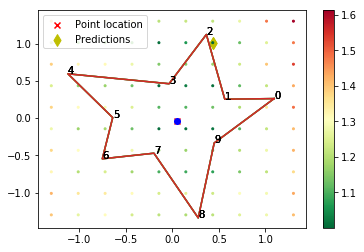

[[ 1.09251426  0.26099942]
 [ 0.5628476   0.25290834]
 [ 0.36518076  1.1214356 ]
 [-0.03529952  0.46030288]
 [-1.12143859  0.5935934 ]
 [-0.64061702  0.00568844]
 [-0.75227927 -0.54743651]
 [-0.19792689 -0.47202716]
 [ 0.27777581 -1.34064152]
 [ 0.44924287 -0.33482291]]


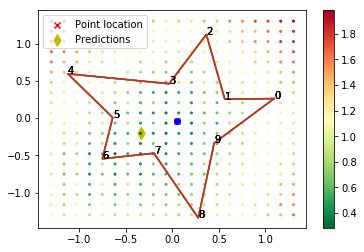

[[ 1.09251426  0.26099942]
 [ 0.5628476   0.25290834]
 [ 0.36518076  1.1214356 ]
 [-0.03529952  0.46030288]
 [-1.12143859  0.5935934 ]
 [-0.64061702  0.00568844]
 [-0.75227927 -0.54743651]
 [-0.19792689 -0.47202716]
 [ 0.27777581 -1.34064152]
 [ 0.44924287 -0.33482291]]


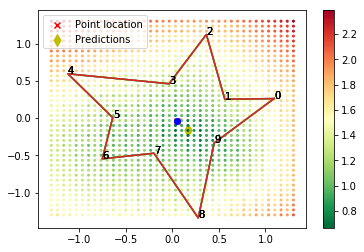

11 -0.06033574411241774 0.06911362276797743 -0
[[ 1.2776988  -0.04440985]
 [ 0.43561161  0.2174618 ]
 [ 0.26510063  0.66764167]
 [-0.28049433  0.50309801]
 [-1.02923732  0.92419684]
 [-0.61705582  0.08008733]
 [-0.41661259 -0.45657619]
 [-0.61202226 -1.26554101]
 [ 0.19784755 -0.41721451]
 [ 0.77916372 -0.2087441 ]]


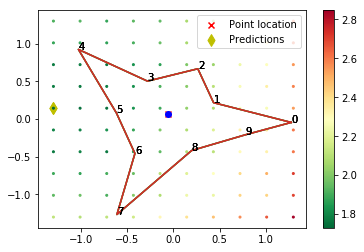

[[ 1.2776988  -0.04440985]
 [ 0.43561161  0.2174618 ]
 [ 0.26510063  0.66764167]
 [-0.28049433  0.50309801]
 [-1.02923732  0.92419684]
 [-0.61705582  0.08008733]
 [-0.41661259 -0.45657619]
 [-0.61202226 -1.26554101]
 [ 0.19784755 -0.41721451]
 [ 0.77916372 -0.2087441 ]]


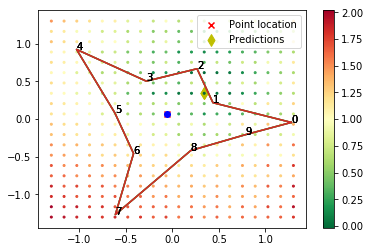

[[ 1.2776988  -0.04440985]
 [ 0.43561161  0.2174618 ]
 [ 0.26510063  0.66764167]
 [-0.28049433  0.50309801]
 [-1.02923732  0.92419684]
 [-0.61705582  0.08008733]
 [-0.41661259 -0.45657619]
 [-0.61202226 -1.26554101]
 [ 0.19784755 -0.41721451]
 [ 0.77916372 -0.2087441 ]]


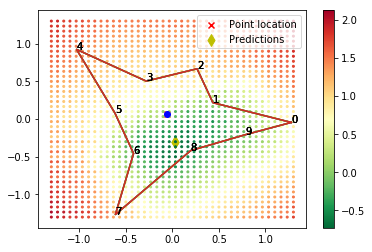

11 -0.0519964694359893 0.0881100850274818 0
[[ 0.68404111  0.05613427]
 [ 1.02408411  0.68920526]
 [ 0.0694163   0.54248628]
 [-0.32444456  1.11600005]
 [-0.4606551   0.38793474]
 [-1.17221659 -0.2274322 ]
 [-0.49226793 -0.30994649]
 [-0.3042445  -0.99824019]
 [ 0.12308584 -0.31142141]
 [ 0.85320131 -0.94472032]]


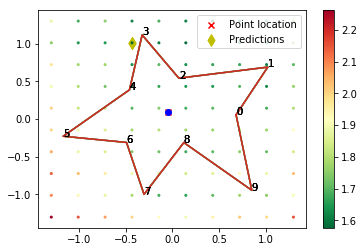

[[ 0.68404111  0.05613427]
 [ 1.02408411  0.68920526]
 [ 0.0694163   0.54248628]
 [-0.32444456  1.11600005]
 [-0.4606551   0.38793474]
 [-1.17221659 -0.2274322 ]
 [-0.49226793 -0.30994649]
 [-0.3042445  -0.99824019]
 [ 0.12308584 -0.31142141]
 [ 0.85320131 -0.94472032]]


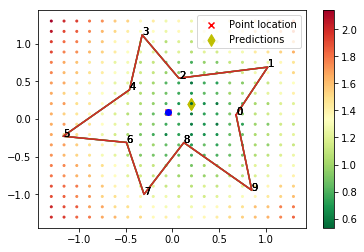

[[ 0.68404111  0.05613427]
 [ 1.02408411  0.68920526]
 [ 0.0694163   0.54248628]
 [-0.32444456  1.11600005]
 [-0.4606551   0.38793474]
 [-1.17221659 -0.2274322 ]
 [-0.49226793 -0.30994649]
 [-0.3042445  -0.99824019]
 [ 0.12308584 -0.31142141]
 [ 0.85320131 -0.94472032]]


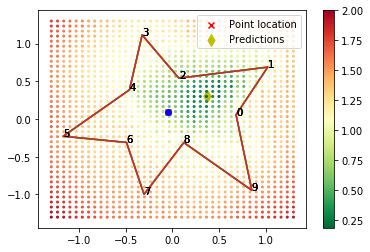

11 0.1065769481340493 -0.0006473960144732216 0
[[ 0.85544448 -0.18032836]
 [ 0.60156327  0.65134464]
 [ 0.09050574  1.34423078]
 [-0.26701249  0.59545555]
 [-0.70910361  0.41682285]
 [-0.51753566  0.0516441 ]
 [-0.8988617  -0.68882322]
 [-0.25192484 -0.44848901]
 [ 0.21892692 -0.67351128]
 [ 0.87799788 -1.06834604]]


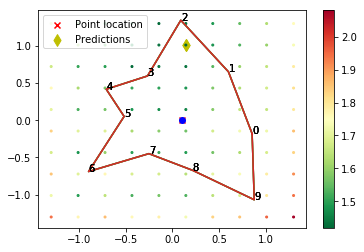

[[ 0.85544448 -0.18032836]
 [ 0.60156327  0.65134464]
 [ 0.09050574  1.34423078]
 [-0.26701249  0.59545555]
 [-0.70910361  0.41682285]
 [-0.51753566  0.0516441 ]
 [-0.8988617  -0.68882322]
 [-0.25192484 -0.44848901]
 [ 0.21892692 -0.67351128]
 [ 0.87799788 -1.06834604]]


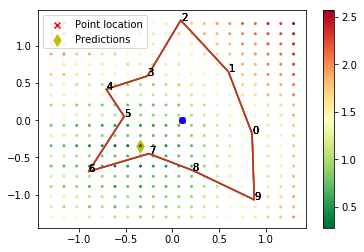

[[ 0.85544448 -0.18032836]
 [ 0.60156327  0.65134464]
 [ 0.09050574  1.34423078]
 [-0.26701249  0.59545555]
 [-0.70910361  0.41682285]
 [-0.51753566  0.0516441 ]
 [-0.8988617  -0.68882322]
 [-0.25192484 -0.44848901]
 [ 0.21892692 -0.67351128]
 [ 0.87799788 -1.06834604]]


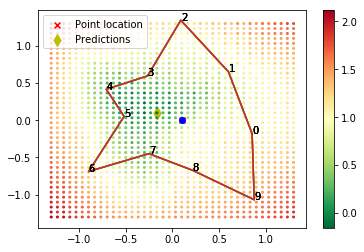

11 -0.02871259585143025 0.06913049140073888 -0
[[ 0.6410417  -0.04458176]
 [ 0.45406582  0.41737635]
 [ 0.57184056  1.13876881]
 [-0.14069283  0.6537762 ]
 [-0.9606707   0.57369793]
 [-0.65105249  0.01808201]
 [-0.96108736 -0.84368199]
 [-0.31813587 -0.679638  ]
 [ 0.29699766 -0.42912948]
 [ 1.06769352 -0.80467006]]


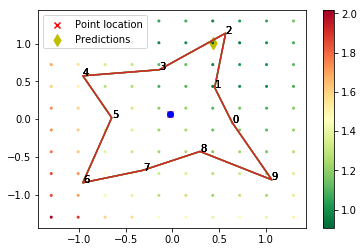

[[ 0.6410417  -0.04458176]
 [ 0.45406582  0.41737635]
 [ 0.57184056  1.13876881]
 [-0.14069283  0.6537762 ]
 [-0.9606707   0.57369793]
 [-0.65105249  0.01808201]
 [-0.96108736 -0.84368199]
 [-0.31813587 -0.679638  ]
 [ 0.29699766 -0.42912948]
 [ 1.06769352 -0.80467006]]


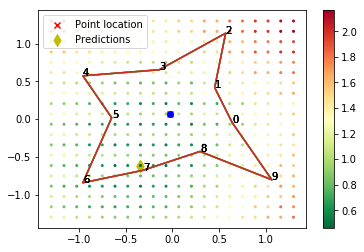

[[ 0.6410417  -0.04458176]
 [ 0.45406582  0.41737635]
 [ 0.57184056  1.13876881]
 [-0.14069283  0.6537762 ]
 [-0.9606707   0.57369793]
 [-0.65105249  0.01808201]
 [-0.96108736 -0.84368199]
 [-0.31813587 -0.679638  ]
 [ 0.29699766 -0.42912948]
 [ 1.06769352 -0.80467006]]


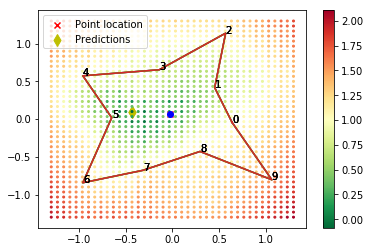

11 -0.02823369808016717 -0.04035539479308997 0
[[ 1.30395247 -0.20499729]
 [ 0.62427776  0.45145638]
 [ 0.39974275  1.35150906]
 [-0.30772989  0.58855317]
 [-0.95671054  0.45551275]
 [-0.70976703 -0.03985901]
 [-0.44878558 -0.50931282]
 [-0.43551598 -1.01186442]
 [ 0.01542344 -0.67025848]
 [ 0.5151126  -0.41073933]]


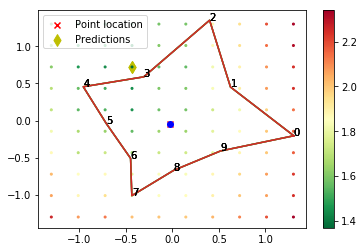

[[ 1.30395247 -0.20499729]
 [ 0.62427776  0.45145638]
 [ 0.39974275  1.35150906]
 [-0.30772989  0.58855317]
 [-0.95671054  0.45551275]
 [-0.70976703 -0.03985901]
 [-0.44878558 -0.50931282]
 [-0.43551598 -1.01186442]
 [ 0.01542344 -0.67025848]
 [ 0.5151126  -0.41073933]]


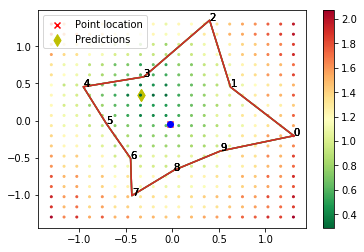

[[ 1.30395247 -0.20499729]
 [ 0.62427776  0.45145638]
 [ 0.39974275  1.35150906]
 [-0.30772989  0.58855317]
 [-0.95671054  0.45551275]
 [-0.70976703 -0.03985901]
 [-0.44878558 -0.50931282]
 [-0.43551598 -1.01186442]
 [ 0.01542344 -0.67025848]
 [ 0.5151126  -0.41073933]]


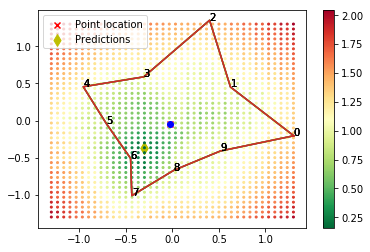

11 -0.01902564629091782 -0.06893638121740087 0
[[ 0.48311329 -0.02070962]
 [ 0.87122058  0.73935874]
 [ 0.22946817  0.37006266]
 [-0.29119022  1.23210834]
 [-0.44802859  0.31754786]
 [-1.1551774   0.18837312]
 [-0.42783932 -0.36447101]
 [-0.26949961 -1.35093737]
 [ 0.20900687 -0.70087198]
 [ 0.79892623 -0.41046074]]


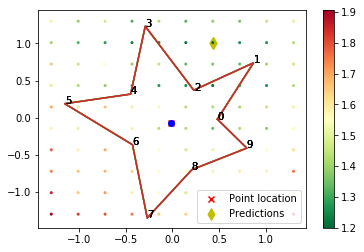

[[ 0.48311329 -0.02070962]
 [ 0.87122058  0.73935874]
 [ 0.22946817  0.37006266]
 [-0.29119022  1.23210834]
 [-0.44802859  0.31754786]
 [-1.1551774   0.18837312]
 [-0.42783932 -0.36447101]
 [-0.26949961 -1.35093737]
 [ 0.20900687 -0.70087198]
 [ 0.79892623 -0.41046074]]


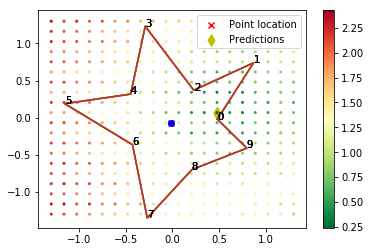

[[ 0.48311329 -0.02070962]
 [ 0.87122058  0.73935874]
 [ 0.22946817  0.37006266]
 [-0.29119022  1.23210834]
 [-0.44802859  0.31754786]
 [-1.1551774   0.18837312]
 [-0.42783932 -0.36447101]
 [-0.26949961 -1.35093737]
 [ 0.20900687 -0.70087198]
 [ 0.79892623 -0.41046074]]


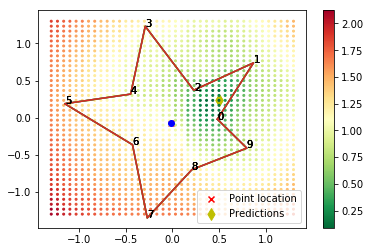

11 -0.0005441471785885261 -0.05867643407467901 0
[[ 0.51852934  0.11966826]
 [ 0.78167937  0.60119039]
 [ 0.1249564   0.57106709]
 [-0.30192796  0.91469432]
 [-0.31088709  0.39401703]
 [-1.33707014  0.16535   ]
 [-0.47214609 -0.33945344]
 [-0.50198488 -1.05687064]
 [ 0.32266332 -0.71252429]
 [ 1.17618773 -0.65713872]]


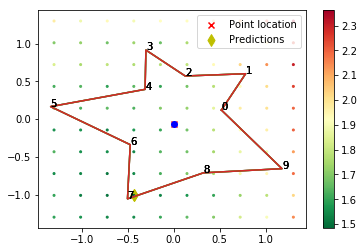

[[ 0.51852934  0.11966826]
 [ 0.78167937  0.60119039]
 [ 0.1249564   0.57106709]
 [-0.30192796  0.91469432]
 [-0.31088709  0.39401703]
 [-1.33707014  0.16535   ]
 [-0.47214609 -0.33945344]
 [-0.50198488 -1.05687064]
 [ 0.32266332 -0.71252429]
 [ 1.17618773 -0.65713872]]


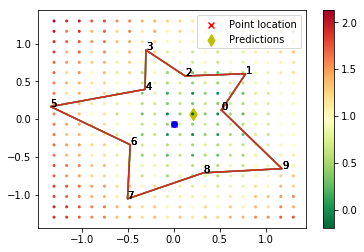

[[ 0.51852934  0.11966826]
 [ 0.78167937  0.60119039]
 [ 0.1249564   0.57106709]
 [-0.30192796  0.91469432]
 [-0.31088709  0.39401703]
 [-1.33707014  0.16535   ]
 [-0.47214609 -0.33945344]
 [-0.50198488 -1.05687064]
 [ 0.32266332 -0.71252429]
 [ 1.17618773 -0.65713872]]


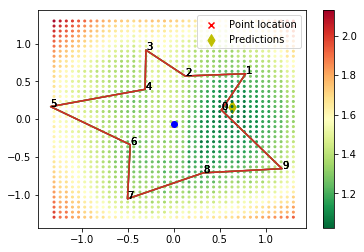

11 0.0577906686355111 -0.0214204285493089 0
[[ 1.00482348  0.06813583]
 [ 0.54148937  0.38225854]
 [ 0.19814998  1.21333587]
 [-0.12997962  0.45402563]
 [-0.73314584  0.91685145]
 [-0.68140221 -0.10081303]
 [-0.60507538 -0.78170166]
 [-0.14264885 -0.49166572]
 [ 0.04630443 -1.38515162]
 [ 0.50148465 -0.27527528]]


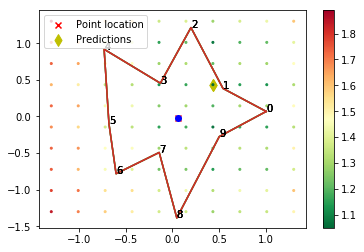

[[ 1.00482348  0.06813583]
 [ 0.54148937  0.38225854]
 [ 0.19814998  1.21333587]
 [-0.12997962  0.45402563]
 [-0.73314584  0.91685145]
 [-0.68140221 -0.10081303]
 [-0.60507538 -0.78170166]
 [-0.14264885 -0.49166572]
 [ 0.04630443 -1.38515162]
 [ 0.50148465 -0.27527528]]


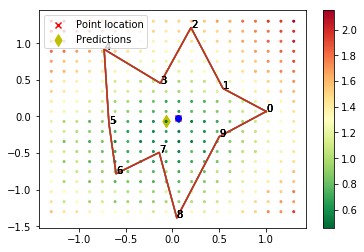

[[ 1.00482348  0.06813583]
 [ 0.54148937  0.38225854]
 [ 0.19814998  1.21333587]
 [-0.12997962  0.45402563]
 [-0.73314584  0.91685145]
 [-0.68140221 -0.10081303]
 [-0.60507538 -0.78170166]
 [-0.14264885 -0.49166572]
 [ 0.04630443 -1.38515162]
 [ 0.50148465 -0.27527528]]


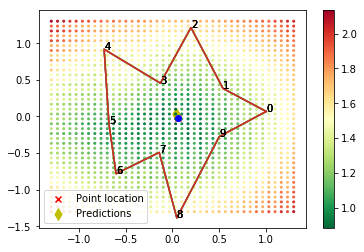

11 -0.07281320669818277 0.1251788698241384 -0
[[ 0.90878577 -0.03198126]
 [ 0.4756925   0.41905826]
 [ 0.05442318  1.05366981]
 [-0.06394115  0.75304397]
 [-0.6384676   0.27391455]
 [-1.25047501  0.27330115]
 [-0.43853772 -0.34367369]
 [-0.41159816 -1.02988786]
 [ 0.30118793 -0.47644873]
 [ 1.06293027 -0.89099619]]


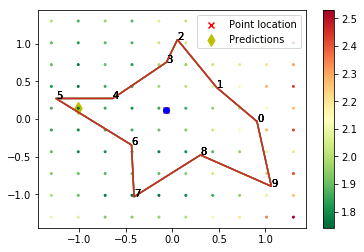

[[ 0.90878577 -0.03198126]
 [ 0.4756925   0.41905826]
 [ 0.05442318  1.05366981]
 [-0.06394115  0.75304397]
 [-0.6384676   0.27391455]
 [-1.25047501  0.27330115]
 [-0.43853772 -0.34367369]
 [-0.41159816 -1.02988786]
 [ 0.30118793 -0.47644873]
 [ 1.06293027 -0.89099619]]


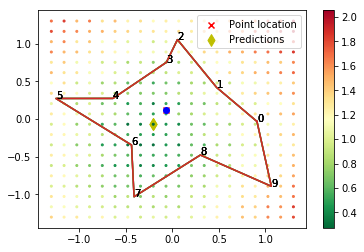

[[ 0.90878577 -0.03198126]
 [ 0.4756925   0.41905826]
 [ 0.05442318  1.05366981]
 [-0.06394115  0.75304397]
 [-0.6384676   0.27391455]
 [-1.25047501  0.27330115]
 [-0.43853772 -0.34367369]
 [-0.41159816 -1.02988786]
 [ 0.30118793 -0.47644873]
 [ 1.06293027 -0.89099619]]


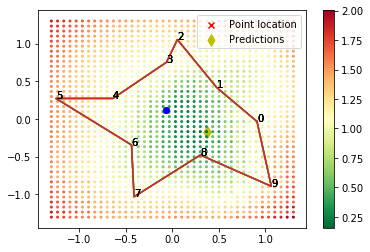

11 0.02073975174472703 0.1203664596631808 0
[[ 0.48855542 -0.06765779]
 [ 1.02140365  0.74543917]
 [ 0.16128945  0.60456725]
 [-0.40537005  1.17641683]
 [-0.49862727  0.26559288]
 [-1.16288546  0.02579563]
 [-0.31911711 -0.25206062]
 [-0.36110355 -1.1360858 ]
 [ 0.28448806 -0.59857396]
 [ 0.79136686 -0.76343358]]


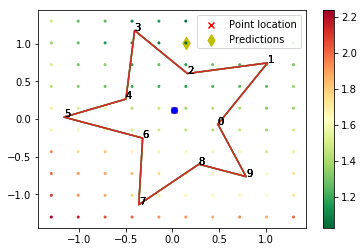

[[ 0.48855542 -0.06765779]
 [ 1.02140365  0.74543917]
 [ 0.16128945  0.60456725]
 [-0.40537005  1.17641683]
 [-0.49862727  0.26559288]
 [-1.16288546  0.02579563]
 [-0.31911711 -0.25206062]
 [-0.36110355 -1.1360858 ]
 [ 0.28448806 -0.59857396]
 [ 0.79136686 -0.76343358]]


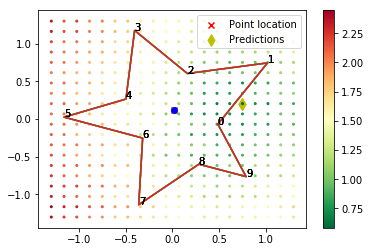

[[ 0.48855542 -0.06765779]
 [ 1.02140365  0.74543917]
 [ 0.16128945  0.60456725]
 [-0.40537005  1.17641683]
 [-0.49862727  0.26559288]
 [-1.16288546  0.02579563]
 [-0.31911711 -0.25206062]
 [-0.36110355 -1.1360858 ]
 [ 0.28448806 -0.59857396]
 [ 0.79136686 -0.76343358]]


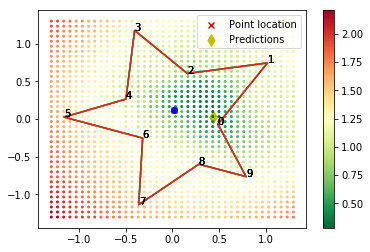

11 0.1195584450227815 0.1049968643170607 0
[[ 0.93810085  0.03820441]
 [ 0.58777233  0.37414111]
 [ 0.24081737  1.01739077]
 [ 0.05840612  0.59434147]
 [-1.14875334  0.67956974]
 [-0.36515664  0.01417264]
 [-0.90700403 -0.7878196 ]
 [-0.21570395 -0.42460193]
 [ 0.32909343 -1.27644405]
 [ 0.48242786 -0.22895453]]


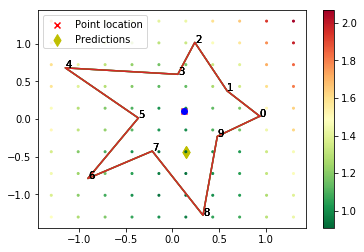

[[ 0.93810085  0.03820441]
 [ 0.58777233  0.37414111]
 [ 0.24081737  1.01739077]
 [ 0.05840612  0.59434147]
 [-1.14875334  0.67956974]
 [-0.36515664  0.01417264]
 [-0.90700403 -0.7878196 ]
 [-0.21570395 -0.42460193]
 [ 0.32909343 -1.27644405]
 [ 0.48242786 -0.22895453]]


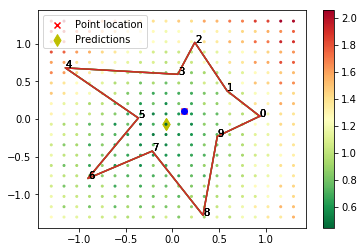

[[ 0.93810085  0.03820441]
 [ 0.58777233  0.37414111]
 [ 0.24081737  1.01739077]
 [ 0.05840612  0.59434147]
 [-1.14875334  0.67956974]
 [-0.36515664  0.01417264]
 [-0.90700403 -0.7878196 ]
 [-0.21570395 -0.42460193]
 [ 0.32909343 -1.27644405]
 [ 0.48242786 -0.22895453]]


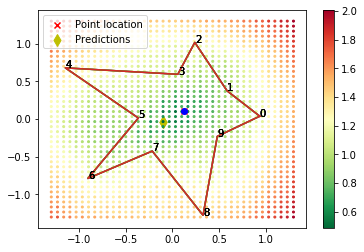

In [30]:
#  Testing convengenge of points with multiple grid resolutions


nb_of_edges=10
nb_of_points=1
nb_of_grid_points_list=[10,20,40]

plt.clf()

count=0
for indices,random_contour in enumerate(random_contour_list):
    #random_contour=apply_procrustes(generate_contour(nb_of_edges))
    random_nb_of_points,random_point_coordinated_delaunay=get_extrapoints_target_length(random_contour,1,algorithm='del2d')
    #if random_nb_of_points==nb_of_points:
     #     break
    random_contour_reshaped=random_contour.reshape(1,2*nb_of_edges)
    random_contour_with_target=np.hstack([random_contour_reshaped,[[1]]])
    count+=1
    predicted_points_grid_resolution=[]

    for nb_of_grid_points in nb_of_grid_points_list:

        X=np.linspace(-1.3,1.3,nb_of_grid_points)
        Y=np.linspace(-1.3,1.3,nb_of_grid_points)
        XX,YY=np.meshgrid(X,Y)
        grid_points=np.array([[x,y] for x in X for y in Y])


        nb_sectors=int(nb_of_grid_points/2)
        sectors,indices=seperate_to_sectors(grid_points,nb_sectors)







        grid_step_size=int(nb_of_grid_points/nb_sectors)

        plot_contour(random_contour)
        random_point_coordinated_delaunay=np.array(random_point_coordinated_delaunay)
        random_point_coordinated_delaunay.reshape(nb_of_points,2)
        plt.scatter(random_point_coordinated_delaunay[:,0],random_point_coordinated_delaunay[:,1],marker='x',c='r',label='Point location')
        my_net=load_network(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN.pkl')
        my_net=my_net.cpu()
        my_net.eval()
        random_grid_qualities=[]
        random_sector_qualities=[]

        for sector in sectors:
            random_contour_with_sector_points=np.hstack([random_contour_with_target,sector.reshape(1,2*len(sector))])
            random_contour_with_sector_points=Variable(torch.from_numpy(random_contour_with_sector_points))
            random_contour_with_sector_points=random_contour_with_sector_points.expand(1000,random_contour_with_sector_points.shape[1]).type(torch.FloatTensor)
            random_sector_quality=my_net(random_contour_with_sector_points)
            random_sector_quality=random_sector_quality.data[0]
            random_sector_quality=random_sector_quality.numpy()
            random_sector_qualities.append(random_sector_quality)
        random_sector_qualities=np.array(random_sector_qualities)

        grid_qualities=np.empty((grid_step_size**2)*(nb_sectors**2))
        for index,point_index in enumerate(indices):
            grid_qualities[point_index]=random_sector_qualities.flatten()[index]

    
    

        grid_qualities_duplicate=grid_qualities.flatten()

        predicted_points=[]
        label_added=False
        for i in range(nb_of_points):
            minimum_index=np.argmin(grid_qualities_duplicate)
            surrounding_points_index=np.array([minimum_index+1,minimum_index-1,minimum_index+nb_of_grid_points
                        ,minimum_index-nb_of_grid_points,minimum_index-nb_of_grid_points+1,minimum_index-nb_of_grid_points-1,
                        minimum_index+nb_of_grid_points+1,minimum_index+nb_of_grid_points-1])

    
            surrounding_points_index_2_ring=np.array([minimum_index+2,minimum_index-2,
                        minimum_index+2*nb_of_grid_points,
                        minimum_index+2*nb_of_grid_points+2,minimum_index+2*nb_of_grid_points-2,
                        minimum_index+2*nb_of_grid_points+1,minimum_index+2*nb_of_grid_points-1,                      
                                              
                                              
                        minimum_index-2*nb_of_grid_points,
                        minimum_index-2*nb_of_grid_points+1,minimum_index-2*nb_of_grid_points-1, 
                        minimum_index-2*nb_of_grid_points+2, minimum_index-2*nb_of_grid_points-2 ,
                                              
                        minimum_index+2,
                        minimum_index-2 ,
                        minimum_index+nb_of_grid_points+2,
                        minimum_index+nb_of_grid_points-2,
                                              
                        minimum_index-nb_of_grid_points+2,
                        minimum_index-nb_of_grid_points-2,


                                                                
                ])
        
            surrounding_points_index_3_ring=np.append(surrounding_points_index_2_ring
                                                ,
                                             [ minimum_index+3,minimum_index+3,
                        minimum_index+3*nb_of_grid_points,
                        minimum_index+3*nb_of_grid_points+3,minimum_index+3*nb_of_grid_points-3,
                        minimum_index+3*nb_of_grid_points+2,minimum_index+3*nb_of_grid_points-2,                      
                                              
                                              
                        minimum_index-3*nb_of_grid_points,
                        minimum_index-3*nb_of_grid_points+2,minimum_index-3*nb_of_grid_points-2, 
                        minimum_index-3*nb_of_grid_points+3, minimum_index-3*nb_of_grid_points-3 ,
                                              
                        minimum_index+3,
                        minimum_index-3 ,
                        minimum_index+nb_of_grid_points+3,
                        minimum_index+nb_of_grid_points-3,
                                              
                        minimum_index-nb_of_grid_points+3,
                        minimum_index-nb_of_grid_points-3] )
    
    
            surrounding_points=grid_points[np.asarray(surrounding_points_index)]
            if int(nb_of_grid_points)>10:
                surrounding_points_2_ring=grid_points[np.asarray(surrounding_points_index_2_ring)]
            point_maximum=grid_points[minimum_index]
            if not label_added:
        
                plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=70,c='y',label='Predictions')
                label_added=True
            plt.scatter(point_maximum[0],point_maximum[1],marker='d',s=70,c='y')
    #plt.scatter(surrounding_points[:,0],surrounding_points[:,1],marker='d',s=34)
    #plt.scatter(surrounding_points_2_ring[:,0],surrounding_points_2_ring[:,1],marker='d',s=34)
            predicted_points.append(point_maximum)
            grid_qualities_duplicate[minimum_index]=100
            grid_qualities_duplicate[np.asarray(surrounding_points_index)]=100
            if int(nb_of_grid_points)>10:
                grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
            if int(nb_of_grid_points)>20:
                grid_qualities_duplicate[np.asarray(surrounding_points_index_2_ring)]=100
        predicted_points_grid_resolution.append(predicted_points)

        plot_contour(random_contour)
        print(random_contour)

        plt.legend()
        plot_grid_qualities(random_contour,grid_qualities,grid_points,random_point_coordinated_delaunay)
        plt.savefig('errors_'+str(count)+'_'+str(nb_of_grid_points)+'_'+'.png',bbox_inches='tight')

        #random_contour_list.append(random_contour)
        plt.show()
        plt.close()

In [51]:

nb_of_edges=8
nb_of_points=6
nb_of_grid_points=20




directory='../polygon_datasets/validation_sets/grid_patch_regression/'
polygon_data=str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_polygon_data.pkl'
point_coordinates=str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_point_coordinates.pkl'
estimated_points=str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_valdation_estimated_points_additional.pkl'
interpolatd_estimated_points=str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_valdation_estimated_interpolated_points_additional.pkl'
polygons=[]

if nb_of_points==1:
    
    with open(os.path.join(directory,polygon_data),'rb') as f:
        polygons=pickle.load(f)
else:
    with open(os.path.join(directory,polygon_data),'rb') as f:
        try:
            while True:
                polygons.append(pickle.load(f))
        except EOFError:
            pass

point_coordinates_list=[]
with open(os.path.join(directory,point_coordinates),'rb') as f:
    try:
        while True:
            point_coordinates_list.append(pickle.load(f))
    except EOFError:
        pass
    
with open(os.path.join(directory,estimated_points),'rb') as f:
    estimated_points=pickle.load(f)
    

In [109]:
#################### Extract estimated  points and interpolate them  for validation sets #############################

nb_of_edges=8
nb_of_points=2
nb_of_grid_points=20


X=np.linspace(-1.3,1.3,nb_of_grid_points)
Y=np.linspace(-1.3,1.3,nb_of_grid_points)
XX,YY=np.meshgrid(X,Y)
grid_points=np.array([[x,y] for x in X for y in Y])
    
nb_sectors=int(nb_of_grid_points/2)
sectors,indices=seperate_to_sectors(grid_points,nb_sectors)

contours=[]

estimated_points=[]
interpolated_estimated_points=[]
with open('../polygon_datasets/validation_sets/grid_patch_regression/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_polygon_data.pkl','rb') as f:
    try:
            while True:
                contours.append(pickle.load(f))
    except EOFError:
            pass


target_edge_lengths=[]   
with open('../polygon_datasets/validation_sets/grid_patch_regression/'+str(nb_of_edges)+'_'+str(nb_of_points)+'_valdation_target_edge_lengths.pkl','rb') as f:
    try:
            while True:
                target_edge_lengths.append(pickle.load(f))
    except EOFError:
            pass

for index,random_contour in enumerate(polygons):


    random_contour_with_target=np.hstack([random_contour.reshape(1,2*nb_of_edges),[[target_edge_lengths[index]]]])

    grid_step_size=int(nb_of_grid_points/nb_sectors)

    my_net=load_grid_patch_NN(str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'grid_NN_additional_v2.pkl')


    my_net=my_net.cpu()
    my_net.eval()
    random_grid_qualities=[]
    random_sector_qualities=[]
    for sector in sectors:

        random_contour_with_sector_points=np.hstack([random_contour_with_target,sector.reshape(1,2*len(sector))])
        random_contour_with_sector_points=Variable(torch.from_numpy(random_contour_with_sector_points))
        random_contour_with_sector_points=random_contour_with_sector_points.expand(1000,random_contour_with_sector_points.shape[1]).type(torch.FloatTensor)
        random_sector_quality=my_net(random_contour_with_sector_points)
        random_sector_quality=random_sector_quality.data[0]
        random_sector_quality=random_sector_quality.numpy()
        random_sector_qualities.append(random_sector_quality)
    random_sector_qualities=np.array(random_sector_qualities)


    grid_qualities=np.empty((grid_step_size**2)*(nb_sectors**2))
    for index,point_index in enumerate(indices):
        grid_qualities[point_index]=random_sector_qualities.flatten()[index]

    #plot_grid_qualities(random_contour,grid_qualities,grid_points,random_point_coordinated_delaunay)



    # Select the point based on grid
    predicted_points,surrounding_points_list,grid_qualities_surrounding=select_points(random_contour,grid_points,grid_qualities,nb_of_points,nb_of_grid_points,1)
    estimated_points.append(predicted_points)
    #interpolated_points=[point  for i in range(nb_of_points) for point in bilineaire_interpolation(surrounding_points_list[i],grid_qualities_surrounding[i],predicted_points[i])]
    #print(index,"predicted_point: ",predicted_points, " Interpolated points: ", interpolated_points)
    #interpolated_points=np.array(interpolated_points).reshape(nb_of_points,2)
    #interpolated_estimated_points.append(interpolated_points)
    print("done")


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
index 412 is out of bounds for axis 0 with size 400
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [115]:
directory='../polygon_datasets/validation_sets/grid_patch_regression/'
estimated_points_filename=str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_valdation_estimated_points_v2.pkl'
#interpolated_estimated_points_filename=str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_valdation_estimated_interpolated_points.pkl'

with open(os.path.join(directory,estimated_points_filename),'wb') as f:
    pickle.dump(estimated_points,f)
    
#with open(os.path.join(directory,interpolated_estimated_points_filename),'wb') as f:
 #   pickle.dump(interpolated_estimated_points,f)
    

In [118]:
## Errors on connection using NN and point either estimated or  original ##

estimated_points=str(nb_of_edges)+'_'+str(nb_of_points)+'_'+str(nb_of_grid_points)+'_valdation_estimated_points_additional_v2.pkl'


    
with open(os.path.join(directory,estimated_points),'rb') as f:
    estimated_points=pickle.load(f)
    


delaunay_minimum_qualities=[]
delauney_with_estimated_points_qualities=[]
for index,polygon in enumerate(polygons):
    print("Examining polygon:",index)

    
    point_coordinates_list[index]=sort_points(np.array(point_coordinates_list[index]).reshape(1,2*nb_of_points),nb_of_points)
    #estimated_points[index]=sort_points(np.array(estimated_points[index]).reshape(1,2*nb_of_points),nb_of_points)
    #interpolatd_estimated_points[index]=sort_points(np.array(interpolatd_estimated_points[index]).reshape(1,2*nb_of_points),nb_of_points)

    #estimated_points[index],_=sort_points_filter(np.array(estimated_points[index]).reshape(1,2*nb_of_points),nb_of_points)
    #interpolatd_estimated_points[index],_=sort_points_filter(np.array(interpolatd_estimated_points[index]).reshape(1,2*nb_of_points),nb_of_points)
    
    # Minimum quality of delaunay counterpart #
    minimum_quality_delaunay=Triangulation_with_points.compute_delaunay_minimum_quality_with_points(polygons[index],np.array(point_coordinates_list[index]).reshape(nb_of_points,2))
    delaunay_minimum_qualities.append(minimum_quality_delaunay)
    

    
    # Minimum quality of mesh using calculated Connection Table  with estimated points#
    minimum_quality_with_estimated_points=Triangulation_with_points.compute_delaunay_minimum_quality_with_points(polygons[index],np.array(estimated_points[index]).reshape(nb_of_points,2))
    delauney_with_estimated_points_qualities.append(minimum_quality_with_estimated_points)
    
    
    
    


FileNotFoundError: [Errno 2] No such file or directory: '../polygon_datasets/validation_sets/grid_patch_regression/8_2_20_valdation_estimated_points_additional_v2.pkl'

In [56]:
100 * l2_relative_error(delaunay_minimum_qualities,delauney_with_estimated_points_qualities)[0],l2_relative_error(delaunay_minimum_qualities,delauney_with_estimated_points_qualities)[1]

(34.04265336326364, 80)

In [114]:
index=0
plot_contour(contours[index])
plt.scatter(estimated_points[index][:,0],estimated_points[index][:,1])
#point_coordinates=np.array(point_coordinates_list[index]).reshape(nb_of_points,2)
#plt.scatter(point_coordinates[:,0],point_coordinates[:,1])

In [82]:
point_coordinates[:,1]

array([ 0.20766145,  0.38007707,  0.32668472, -0.04978886, -0.30854727,
       -0.1626305 ])

In [119]:
estimated_points

'8_2_20_valdation_estimated_points_additional_v2.pkl'

In [8]:
polygons_reshaped_with_grid_points


NameError: name 'polygons_reshaped_with_grid_points' is not defined

In [11]:
polygons_reshaped[0]


array([ 0.93459151, -0.01042462,  0.65000186,  0.89942486,  0.06891648,
        0.93667881, -0.98634202,  0.5756463 , -0.63373012,  0.05270776,
       -0.55061244, -0.66360841, -0.06061966, -0.71199005,  0.57779438,
       -1.07843464,  0.2       ])

In [13]:
nb_of_edges,nb_of_points

(8, 6)

In [16]:
polygons_reshaped.shape

(26266, 17)